In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, UpSampling3D, Input, ZeroPadding3D, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.layers import Conv3D, MaxPooling3D
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.constraints import unit_norm, max_norm
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
import numpy as np
import nibabel as nib
import scipy as sp
import scipy.ndimage
from sklearn.metrics import mean_squared_error, r2_score

import sys
import argparse
import os
import glob 

import dcor

In [5]:
import pandas as pd
df = pd.read_csv('C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/df_labels.csv')
df

,Unnamed: 0,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight,fil_path,file_path
0,0,amd_1101816_1,1,late,MNV,1101816,OD,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
1,1,amd_1101816_2,1,late,MNV,1101816,OD,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
2,2,amd_1101816_3,1,late,MNV,1101816,OS,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
3,3,amd_1101816_4,1,late,MNV,1101816,OS,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
4,4,amd_1191668_1,1,intermediate,MNV_suspected,1191668,OD,F,1948,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,417,no_9054704_2,0,emmetropia,NO,9054704,OD,M,1955,882,318,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
414,418,no_9317962_1,0,emmetropia,NO,9317962,OD,F,1947,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
415,419,no_9317962_2,0,emmetropia,NO,9317962,OS,F,1947,882,314,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
416,420,no_9663705_1,0,emmetropia,NO,9663705,OD,F,1952,914,291,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...


In [22]:
def augment_by_transformation(data, age, sex, n):
    """
    Augment data by applying transformations.
    
    Args:
    data (ndarray): Input data.
    age (ndarray): Ages corresponding to data samples.
    sex (ndarray): Sexes corresponding to data samples.
    n (int): Desired number of augmented samples.
    
    Returns:
    ndarray: Augmented data.
    ndarray: Augmented ages.
    ndarray: Augmented sexes.
    """
    augment_scale = 1

    if n <= data.shape[0]:
        return data, age, sex
    else:
        raw_n = data.shape[0]
        m = n - raw_n
        # Ensure new_data has the same dimensions as data
        new_data = np.zeros((m, data.shape[1], data.shape[2], data.shape[3], data.shape[4])) if len(data.shape) == 5 else np.zeros((m, data.shape[1], data.shape[2], data.shape[3]))
        for i in range(0, m):
            idx = np.random.randint(0, raw_n)
            new_age = age[idx]
            new_sex = sex[idx]
            new_data[i] = data[idx].copy()
            new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(1,0), reshape=False)
            new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(0,2), reshape=False)
            new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(1,2), reshape=False)
            new_data[i] = sp.ndimage.shift(new_data[i], np.random.uniform(-0.5, 0.5))

            age = np.append(age, new_age)
            sex = np.append(sex, new_sex)

        data = np.concatenate((data, new_data), axis=0)
        return data, age, sex


In [33]:
import numpy as np
import sys
import dcor
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Disable eager execution
tf.compat.v1.disable_eager_execution()

def inv_mse(y_true, y_pred):
    mse_value = K.sum(K.square(y_true-y_pred))
    return -mse_value

def inv_correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-5
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-5
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

class GAN():
    
    def __init__(self):
        self.lr = 0.0002
        optimizer = Adam(self.lr)
        optimizer_distiller = Adam(self.lr)
        optimizer_regressor = Adam(self.lr)

        L2_reg = 0.1
        ft_bank_baseline = 16
        latent_dim = 16

        # Build and compile the cf predictorinv_inv
        self.regressor = self.build_regressor()
        self.regressor.compile(loss='mse', optimizer=optimizer)

        # Build the feature encoder
        input_image = Input(shape=(512, 512, 1), name='input_image')
        feature = Conv3D(ft_bank_baseline, activation='relu', kernel_size=(3, 3, 3),padding='same')(input_image)
        feature = BatchNormalization()(feature)
        feature = MaxPooling3D(pool_size=(2, 2, 2))(feature)

        feature = Conv3D(ft_bank_baseline*2, activation='relu', kernel_size=(3, 3, 3),padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling3D(pool_size=(2, 2, 2))(feature)

        feature = Conv3D(ft_bank_baseline*4, activation='relu', kernel_size=(3, 3, 3),padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling3D(pool_size=(2, 2, 2))(feature)

        feature = Conv3D(ft_bank_baseline*2, activation='relu', kernel_size=(3, 3, 3),padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling3D(pool_size=(2, 2, 2))(feature)

        feature_dense = Flatten()(feature)
        
        self.encoder = Model(input_image, feature_dense)

        # For the distillation model we will only train the encoder

        self.regressor.trainable = False
        cf = self.regressor(feature_dense)
        self.distiller = Model(input_image, cf)
        self.distiller.compile(loss=correlation_coefficient_loss, optimizer=optimizer)

        # Build and Compile the classifer  
        input_feature_clf = Input(shape=(1024,), name='input_feature_dense')
        feature_clf = Dense(latent_dim*4, activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(input_feature_clf)
        feature_clf = Dense(latent_dim*2, activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(feature_clf)
        prediction_score = Dense(1, name='prediction_score',kernel_regularizer=regularizers.l2(L2_reg))(feature_clf)
        self.classifier = Model(input_feature_clf, prediction_score)

        # Build the entir workflow
        prediction_score_workflow = self.classifier(feature_dense)
        label_workflow = Activation('sigmoid', name='r_mean')(prediction_score_workflow)
        self.workflow = Model(input_image, label_workflow)
        self.workflow.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

    def build_regressor(self):
        latent_dim = 16
        inputs_x = Input(shape=(1024,))
        feature = Dense(latent_dim*4, activation='tanh')(inputs_x)
        feature = Dense(latent_dim*2, activation='tanh')(feature)
        cf = Dense(1)(feature)
        return Model(inputs_x, cf)

    def train(self, epochs, training, testing, testing_raw, batch_size=64, fold=0):
        [train_data_aug, train_dx_aug, train_age_aug, train_sex_aug] = training
        [test_data_aug,  test_dx_aug,  test_age_aug,  test_sex_aug]  = testing
        [test_data    ,  test_dx    ,  test_age,      test_sex   ]   = testing_raw
        
        test_data_aug_flip = np.flip(test_data_aug,1)
        test_data_flip = np.flip(test_data,1)

        idx_perm = np.random.permutation(int(train_data_aug.shape[0]/2))
        
        dc_age = np.zeros((int(epochs/10)+1,))
        min_dc = 0
        for epoch in range(epochs):

            idx_perm = np.random.permutation(int(train_data_aug.shape[0]/2))
            ctrl_idx = idx_perm[:int(batch_size)]
            idx_perm = np.random.permutation(int(train_data_aug.shape[0]/2))
            idx = idx_perm[:int(batch_size/2)]
            idx = np.concatenate((idx,idx+int(train_data_aug.shape[0]/2)))

            training_feature_batch = train_data_aug[idx]
            dx_batch = train_dx_aug[idx]
            age_batch = train_age_aug[idx]

            training_feature_ctrl_batch = train_data_aug[ctrl_idx]
            age_ctrl_batch = train_age_aug[ctrl_idx]

            encoded_feature_ctrl_batch = self.encoder.predict(training_feature_ctrl_batch[:,:32,:,:])
            r_loss = self.regressor.train_on_batch(encoded_feature_ctrl_batch, age_ctrl_batch)

            g_loss = self.distiller.train_on_batch(training_feature_ctrl_batch[:,:32,:,:], age_ctrl_batch)

            c_loss = self.workflow.train_on_batch(training_feature_batch[:,:32,:,:], dx_batch)

            training_feature_batch = np.flip(training_feature_batch,1)
            training_feature_ctrl_batch = np.flip(training_feature_ctrl_batch,1)

            encoded_feature_ctrl_batch = self.encoder.predict(training_feature_ctrl_batch[:,:32:,:])
            r_loss = self.regressor.train_on_batch(encoded_feature_ctrl_batch, age_ctrl_batch)
            g_loss = self.distiller.train_on_batch(training_feature_ctrl_batch[:,:32,:,:], age_ctrl_batch)
            c_loss = self.workflow.train_on_batch(training_feature_batch[:,:32,:,:], dx_batch)

            if epoch % 50 == 0:
                c_loss_test_1 = self.workflow.evaluate(test_data_aug[:,:32,:,:],      test_dx_aug, verbose = 0, batch_size = batch_size)    
                c_loss_test_2 = self.workflow.evaluate(test_data_aug_flip[:,:32,:,:], test_dx_aug, verbose = 0, batch_size = batch_size)    

                features_dense = self.encoder.predict(train_data_aug[train_dx_aug == 0,:32,:,:],  batch_size = batch_size)
                dc_age[int(epoch/10)] = dcor.u_distance_correlation_sqr(features_dense, train_age_aug[train_dx_aug == 0])
                print ("%d [Acc: %f,  Test Acc: %f %f,  dc: %f]" % (epoch, c_loss[1], c_loss_test_1[1], c_loss_test_2[1], dc_age[int(epoch/10)]))
                sys.stdout.flush()

                self.classifier.save_weights("classifier_weights.h5")
                self.encoder.save_weights("encoder_weights.h5")
                self.workflow.save_weights("workflow_weights.h5")

                prediction = self.workflow.predict(test_data[:,:32,:,:],  batch_size = 64)
                np.savetxt("prediction.txt", prediction)
                prediction = self.workflow.predict(test_data_flip[:,:32,:,:],  batch_size = 64)
                np.savetxt("prediction_flip.txt", prediction)

                np.savetxt("dx.txt", test_dx)    
                np.savetxt("cf.txt", test_age)

In [40]:
import numpy as np
import cv2  # or use Pillow for image loading
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm


# Assuming you have a DataFrame named df containing image paths, sex, age, and labels

def load_image(image_path):
    """Load image using OpenCV"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale mode
    # You can also use Pillow if you prefer: img = Image.open(image_path)
    return img

if __name__ == '__main__':
    # Load data from DataFrame
    file_idx = df['file_path'].values
    age = df['year'].values
    sex = df['sex'].values
    labels = df['disease'].values

    np.random.seed(seed=0)

    subject_num = len(file_idx)
    patch_x = 512  # Adjusted to match image dimensions
    patch_y = 512  # Adjusted to match image dimensions
    min_x = 0
    min_y = 0

    augment_size = 512
    data = np.zeros((subject_num, patch_x, patch_y, 1))  # Removed patch_z since it was not used
    i = 0
    for subject_idx in tqdm(range(len(file_idx))):
        filename_full = file_idx[subject_idx]

        # Load image
        img = load_image(filename_full)
        img_data = img[min_x:min_x+patch_x, min_y:min_y+patch_y]
        img_data = np.expand_dims(img_data, axis=-1)  # Add channel dimension
        data[i] = (img_data - np.mean(img_data)) / np.std(img_data)  # Normalize image data

        i += 1

    # Separate data into positive and negative instances
    positive_data = data[labels == 1]
    negative_data = data[labels == 0]
    positive_age = age[labels == 1]
    negative_age = age[labels == 0]
    positive_sex = sex[labels == 1]
    negative_sex = sex[labels == 0]

    # Augment data for positive and negative instances separately
    positive_data_aug, positive_age_aug, positive_sex_aug = augment_by_transformation(positive_data, positive_age, positive_sex, augment_size)
    negative_data_aug, negative_age_aug, negative_sex_aug = augment_by_transformation(negative_data, negative_age, negative_sex, augment_size)

    # Concatenate augmented data
    data_aug = np.concatenate((positive_data_aug, negative_data_aug), axis=0)
    age_aug = np.concatenate((positive_age_aug, negative_age_aug), axis=0)
    sex_aug = np.concatenate((positive_sex_aug, negative_sex_aug), axis=0)
    labels_aug = np.concatenate((np.ones(positive_data_aug.shape[0]), np.zeros(negative_data_aug.shape[0])), axis=0)


    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    pred = np.zeros((labels_aug.shape))

    fold = 1
    for train_idx, test_idx in skf.split(data_aug, labels_aug):
        if fold < 3:
            fold = fold + 1
            continue

        train_data = data_aug[train_idx]
        train_labels = labels_aug[train_idx]
        train_age = age_aug[train_idx]
        train_sex = sex_aug[train_idx]

        test_data = data_aug[test_idx]
        test_labels = labels_aug[test_idx]
        test_age = age_aug[test_idx]
        test_sex = sex_aug[test_idx]

        print('begin training')

        sys.stdout.flush()
        gan = GAN()
        gan.train(epochs=1501, training=[train_data, train_labels, train_age, train_sex], testing=[test_data, test_labels, test_age, test_sex], testing_raw=[test_data, test_labels, test_age, test_sex], batch_size=64, fold=fold)

        fold = fold + 1


100%|██████████| 418/418 [00:01<00:00, 300.66it/s]
C:\Users\hgnik\AppData\Local\Temp\ipykernel_28852\3034005116.py:30: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(1,0), reshape=False)
C:\Users\hgnik\AppData\Local\Temp\ipykernel_28852\3034005116.py:31: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(0,2), reshape=False)
C:\Users\hgnik\AppData\Local\Temp\ipykernel_28852\3034005116.py:32: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(1,2), r

begin training


ValueError: Input 0 of layer "conv3d_3" is incompatible with the layer: expected min_ndim=5, found ndim=4. Full shape received: (None, 512, 512, 1)

Shape of augmented positive data: (512, 512, 512, 1)
Shape of augmented negative data: (512, 512, 512, 1)
Shape of augmented age: (1024,)
Shape of augmented sex: (1024,)
Shape of augmented labels: (1024,)
Visualizing some of the augmented images:


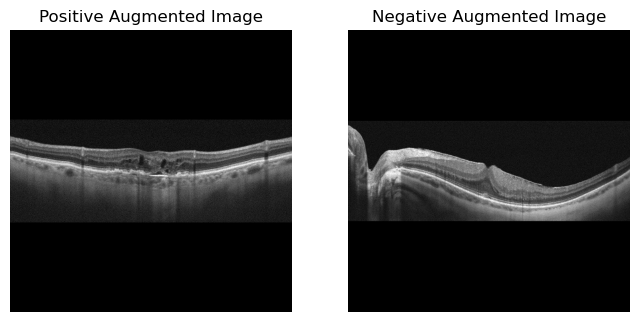

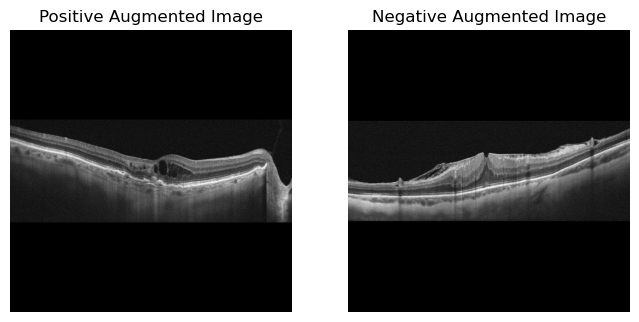

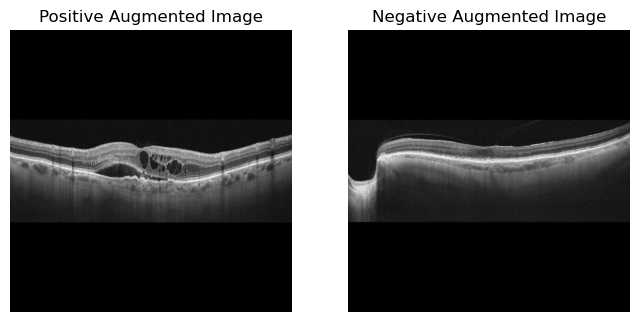

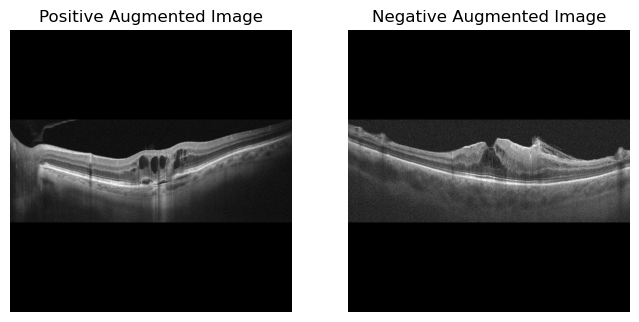

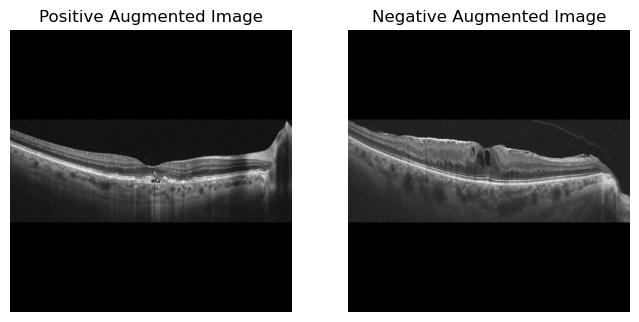

Length whole data: 1024
Length test data: 204
Length train data: 820


In [30]:
import matplotlib.pyplot as plt

# Check the shape of augmented data
print("Shape of augmented positive data:", positive_data_aug.shape)
print("Shape of augmented negative data:", negative_data_aug.shape)
print("Shape of augmented age:", age_aug.shape)
print("Shape of augmented sex:", sex_aug.shape)
print("Shape of augmented labels:", labels_aug.shape)

# Visualize some of the augmented images
n_samples_to_visualize = 5

print("Visualizing some of the augmented images:")
for i in range(n_samples_to_visualize):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(positive_data_aug[i].squeeze(), cmap='gray')
    plt.title("Positive Augmented Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(negative_data_aug[i].squeeze(), cmap='gray')
    plt.title("Negative Augmented Image")
    plt.axis('off')

    plt.show()


print("Length whole data:", len(data_aug))
print("Length test data:", len(test_data))
print("Length train data:", len(train_data))
